In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from fenics import *

from algorithms.matrix_free_rsvd import MatrixFreeRSVD, get_approximate_W, tikhonov_solver
from algorithms.weighted_low_rank_solver import WeightedLowRankSolver
from utils.mesh_utils import get_square_f
from utils.colors import C2

In [5]:
mesh = UnitSquareMesh(64, 64)
V_h = FunctionSpace(mesh, 'CG', 1)

rsvd = MatrixFreeRSVD(V_h)
x0, y0, width, height = 0.1, 0.7, 0.15, 0.15
f = get_square_f(V_h, x0, y0, w=width, h=height)
x = f.vector().get_local()
y = rsvd.apply_K(x)

k = 50
lambda_ = 1e-4
r_s = 1
alpha = 0.2
seed = None

In [6]:
# Approximate SVD K = U S V^T and weights W
Uk, Sk, VkT = rsvd.mf_rsvd(k=k, seed=seed)
w = get_approximate_W(VkT.T, rsvd.M_dx)

# Weighted tikhonov solution
solver = WeightedLowRankSolver(
    V_h=V_h,
    M_dx=rsvd.M_dx,
    M_ds=rsvd.M_ds,
    U=Uk,
    S=Sk,
    VT=VkT,
)
x_tikhonov = tikhonov_solver(
    rsvd=rsvd,
    W_diag=w,
    y=y,
    lambda_=lambda_
)
f_tikhonov = Function(V_h)
f_tikhonov.vector()[:] = x_tikhonov

# Low-rank weighted tikhonov solution
f_low_rank = solver.solve(y,
    r_s=r_s,
    w=w,
    alpha=alpha,       # step size
    lambda_=lambda_,  # regularization param
    max_iter=5000,
    seed=seed
)

[##############################] 5000/5000


In [8]:
x_tikhonov = np.maximum(x_tikhonov, 0)
f_tikhonov.vector()[:] = x_tikhonov

In [16]:
P = np.maximum(solver.P, 5)
Q = np.maximum(solver.Q, 5)
P = blockify(P, 1)
Q = blockify(Q, 1)
X = P @ Q.T
f_low_rank.vector()[:] = solver.matrix_to_vec(X)

In [7]:
def blockify(x, block_size):
    n = len(x)
    y = x.copy()
    for i in range(0, n, block_size):
        y[i:i+block_size] = np.mean(x[i:i+block_size])
    return y

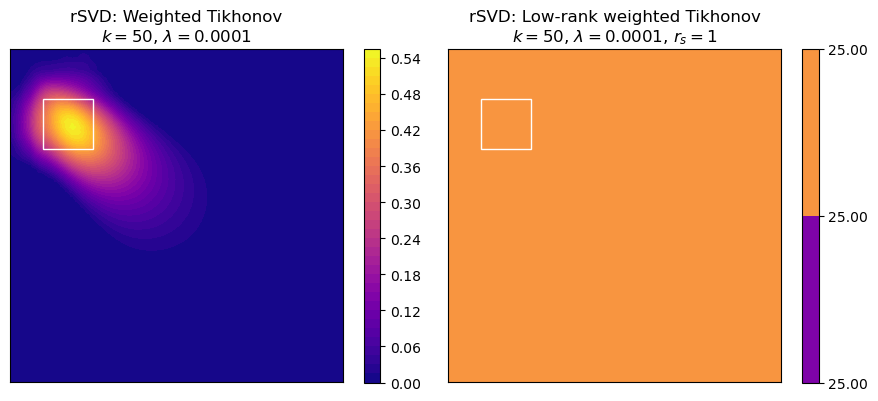

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
ax1, ax2 = axes

plt.sca(ax1)
p = plot(f_tikhonov,
    title=f'rSVD: Weighted Tikhonov\n$k={k}$, $\\lambda={lambda_}$',
    cmap='plasma')
square = patches.Rectangle((x0, y0), width, height, edgecolor='white', facecolor='none')
ax1.add_patch(square)
fig.colorbar(p, ax=ax1, format="%.2f", shrink=0.71)
ax1.set_xticks([])
ax1.set_yticks([])

plt.sca(ax2)
p = plot(f_low_rank,
    title=f'rSVD: Low-rank weighted Tikhonov\n$k={k}$, $\\lambda={lambda_}$, $r_s={r_s}$',
    cmap='plasma')
square = patches.Rectangle((x0, y0), width, height, edgecolor='white', facecolor='none')
ax2.add_patch(square)
fig.colorbar(p, ax=ax2, format="%.2f", shrink=0.71)
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()

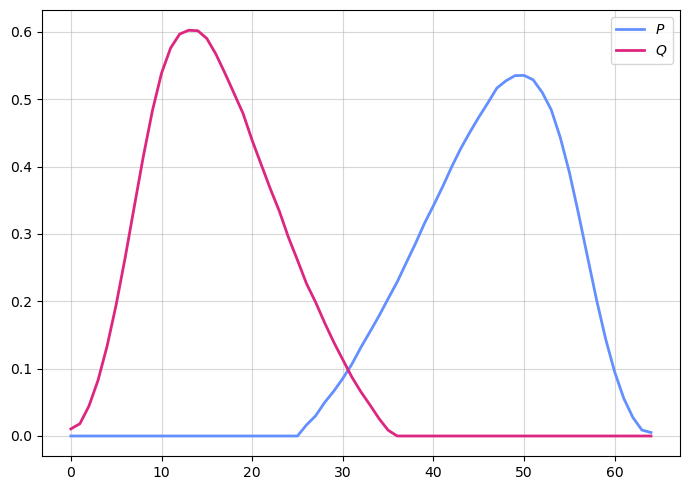

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(P, c=C2[0], label='$P$', lw=2)
ax.plot(Q, c=C2[1], label='$Q$', lw=2)
ax.legend()
ax.grid(alpha=0.5)
plt.tight_layout()
plt.show()